In [9]:
import os
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [11]:
model = keras.models.load_model('ghostfacenet_v1.h5')

In [12]:
dataset_dir = 'dataset'
persons = os.listdir(dataset_dir)

In [34]:
persons = [p for p in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, p)) and not p.startswith('.')]
random.shuffle(persons) 

# Split into enrolled and unenrolled
enrolled_persons = persons[:1500]
unenrolled_persons = persons[1500:]

data = []

for person in enrolled_persons:
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    selected_images = random.sample(images, 2) if len(images) >= 2 else images  
    for image in selected_images:
        data.append([person, os.path.join(person_dir, image), 'Enrolled'])

for person in unenrolled_persons:
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    if images:  # Ensure there is at least one image
        selected_image = random.choice(images)
        data.append([person, os.path.join(person_dir, selected_image), 'Not Enrolled'])

In [36]:
df = pd.DataFrame(data, columns=['Person', 'Image_Path', 'Label'])
print(len(df))  

3500


In [13]:
persons = [p for p in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, p)) and not p.startswith('.')]
random.shuffle(persons) 

# Split into enrolled and unenrolled
enrolled_persons = persons[:1500]
unenrolled_persons = persons[1500:]

data = []

for person in enrolled_persons:
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    selected_images = random.sample(images, 2) if len(images) >= 2 else images  
    for image in selected_images:
        data.append([person, os.path.join(person_dir, image), 'Enrolled'])

for person in unenrolled_persons:
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    if images:  # Ensure there is at least one image
        selected_image = random.choice(images)
        data.append([person, os.path.join(person_dir, selected_image), 'Not Enrolled'])

In [14]:
df = pd.DataFrame(data, columns=['Person', 'Image_Path', 'Label'])
print(len(df))  

3500


In [15]:
df.head()

,Person,Image_Path,Label
0,1593,dataset/1593/24.png,Enrolled
1,1593,dataset/1593/37.png,Enrolled
2,170,dataset/170/9.png,Enrolled
3,170,dataset/170/56.png,Enrolled
4,1961,dataset/1961/69.png,Enrolled


In [21]:
print(len(df))

3500


In [16]:
def generate_pairs(df):
    """Generate all possible genuine pairs and then randomly select impostor pairs to match the number of genuine pairs."""
    genuine_pairs = []
    impostor_pairs = []

    # Generate genuine pairs
    for _, group in df.groupby('Person'):
        genuine_pairs.extend(list(combinations(group['Image_Path'], 2)))

    num_genuine_pairs = len(genuine_pairs)
    unique_person_ids = df['Person'].unique()

    while len(impostor_pairs) < num_genuine_pairs:
        # Randomly select two different persons
        person_a, person_b = random.sample(list(unique_person_ids), 2)

        # Randomly select an image from each person
        path_a = random.choice(df[df['Person'] == person_a]['Image_Path'].tolist())
        path_b = random.choice(df[df['Person'] == person_b]['Image_Path'].tolist())

        # Add this impostor pair to the list
        impostor_pairs.append((path_a, path_b))

    return genuine_pairs, impostor_pairs

In [17]:
genuine_pairs, impostor_pairs = generate_pairs(df)

In [22]:
def get_embedding(model, image_path):
    """
    Get an image embedding using ghostfacenet_v1 model.
    
    Parameters:
    - image_path: Path to the image file.
    
    Returns:
    - embedding: The embedding vector for the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((112, 112))
    img_array = np.array(img).astype('float32')
    
    # Normalize the image data to [-1, 1]
    img_array = (img_array / 127.5) - 1  # Assuming the original range is [0, 255]
    return model.predict(np.expand_dims(img_array, axis=0))


def compute_cosine_distance(features1, features2):
    # Compute and return the cosine distance between two feature vectors
    return cosine_similarity(features1, features2)

def compute_distances(pairs, model):
    """Compute the cosine distance for each pair, handling NaN values."""
    distances = []
    for img_path_a, img_path_b in pairs:

        embedding1 = get_embedding(model, img_path_a)
        embedding2 = get_embedding(model, img_path_b)

        if embedding1 is None or embedding2 is None:
            print(f"Skipping pair {img_path_a}, {img_path_b} due to an error.")
            continue
        # Ensure no NaN values are present in features before computing distance
        if np.isnan(embedding1).any() or np.isnan(embedding2).any():
            print(f"Found NaN in features for pair {img_path_a}, {img_path_b}. Skipping.")
            continue
        # Compute cosine similarity and convert it to distance
        similarity = cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
        distance = 1 - similarity.item()  # Convert numpy array to scalar
        print(f"Distance between {img_path_a} and {img_path_b}: {distance}")
        distances.append(distance)
    return distances

In [19]:
genuine_distances = compute_distances(genuine_pairs, model)

1/1 [==============================] - 0s 28ms/step
Distance between dataset/0/41.png and dataset/0/68.png: 0.6343247890472412
1/1 [==============================] - 0s 31ms/step
Distance between dataset/1/64.png and dataset/1/3.png: 0.5516715943813324
1/1 [==============================] - 0s 31ms/step
Distance between dataset/10/14.png and dataset/10/38.png: 0.7100310623645782
1/1 [==============================] - 0s 28ms/step
Distance between dataset/100/47.png and dataset/100/59.png: 0.3819091320037842
1/1 [==============================] - 0s 28ms/step
Distance between dataset/1000/1.png and dataset/1000/44.png: 0.8937320113182068
1/1 [==============================] - 0s 28ms/step
Distance between dataset/1002/19.png and dataset/1002/68.png: 0.8095535337924957
1/1 [==============================] - 0s 29ms/step
Distance between dataset/1003/50.png and dataset/1003/52.png: 0.4596584439277649
1/1 [==============================] - 0s 28ms/step
Distance between dataset/1005/59.png 

In [20]:
impostor_distances = compute_distances(impostor_pairs, model)

1/1 [==============================] - 0s 35ms/step
Distance between dataset/1157/69.png and dataset/25/30.png: 0.7674577236175537
1/1 [==============================] - 0s 35ms/step
Distance between dataset/1474/16.png and dataset/1831/38.png: 0.8917635604739189
1/1 [==============================] - 0s 37ms/step
Distance between dataset/387/31.png and dataset/88/19.png: 0.8841723948717117
1/1 [==============================] - 0s 39ms/step
Distance between dataset/1835/4.png and dataset/998/5.png: 1.0222360454499722
1/1 [==============================] - 0s 37ms/step
Distance between dataset/1157/69.png and dataset/1357/12.png: 0.8180897533893585
1/1 [==============================] - 0s 35ms/step
Distance between dataset/909/36.png and dataset/1752/45.png: 0.8632948100566864
1/1 [==============================] - 0s 31ms/step
Distance between dataset/804/32.png and dataset/1806/41.png: 0.8980825394392014
1/1 [==============================] - 0s 36ms/step
Distance between dataset/15

In [23]:
def evaluate_threshold(distances, threshold):
    """Evaluate pairs against the threshold to determine matches and non-matches."""
    matches = [distance <= threshold for distance in distances]
    return matches

def calculate_metrics(genuine_distances, impostor_distances, threshold):
    """Calculate evaluation metrics based on distances and a threshold."""
    genuine_matches = evaluate_threshold(genuine_distances, threshold)
    impostor_matches = evaluate_threshold(impostor_distances, threshold)

    # True Positive: Genuine pair correctly matched
    tp = sum(genuine_matches)
    # False Positive: Impostor pair incorrectly matched
    fp = sum(impostor_matches)
    # True Negative: Impostor pair correctly not matched
    tn = len(impostor_matches) - fp
    # False Negative: Genuine pair incorrectly not matched
    fn = len(genuine_matches) - tp

    # Example metric calculations
    far = fp / (fp + tn)  # False Acceptance Rate
    frr = fn / (fn + tp)  # False Rejection Rate

    return {'FAR': far, 'FRR': frr}

In [24]:
# Main evaluation
thresholds = np.arange(0.01, 1.0, 0.01)
results = {}

for threshold in thresholds:
    metrics = calculate_metrics(genuine_distances, impostor_distances, threshold)
    results[threshold] = metrics

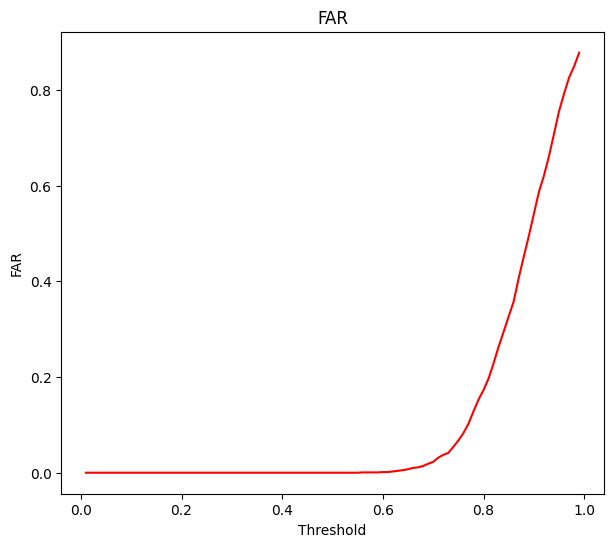

In [25]:
thresholds = [key for key in results.keys()]
far = [results[thresh]['FAR'] for thresh in thresholds]


plt.figure(figsize=(7, 6)) 
plt.plot(thresholds, far, linestyle='-', color='r')
plt.title('FAR')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

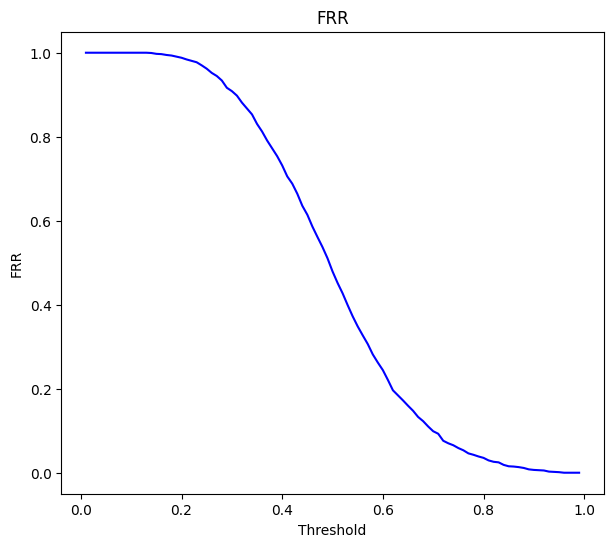

In [26]:
frr = [results[thresh]['FRR'] for thresh in thresholds]
plt.figure(figsize=(7, 6))
plt.plot(thresholds, frr, linestyle='-', color='b')
plt.title('FRR')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

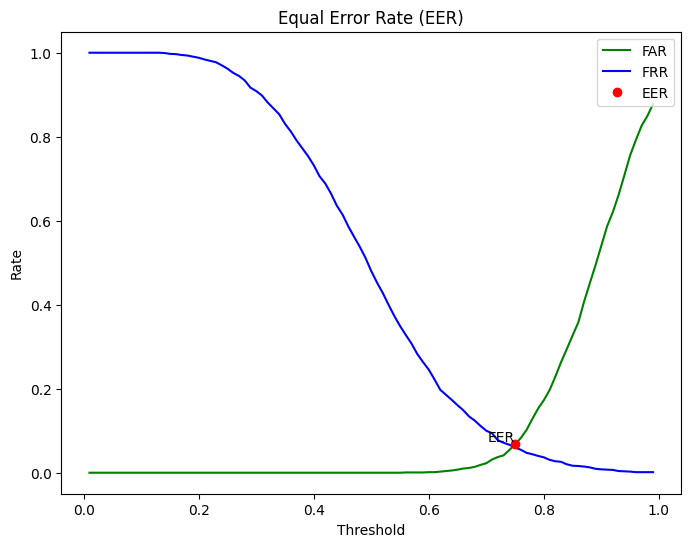

In [27]:
eer_index = np.argmin(np.abs(np.array(far) - np.array(frr)))
eer_FAR = far[eer_index]
eer_threshold = thresholds[eer_index]

# Plot FAR and FRR against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, linestyle='-', color='g', label='FAR')
plt.plot(thresholds, frr, linestyle='-', color='b', label='FRR')
plt.plot(eer_threshold, eer_FAR, 'ro', label='EER')
plt.text(eer_threshold, eer_FAR, 'EER', color='black', ha='right', va='bottom')

# Setting up the plot
plt.title('Equal Error Rate (EER)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='upper right')
plt.show()

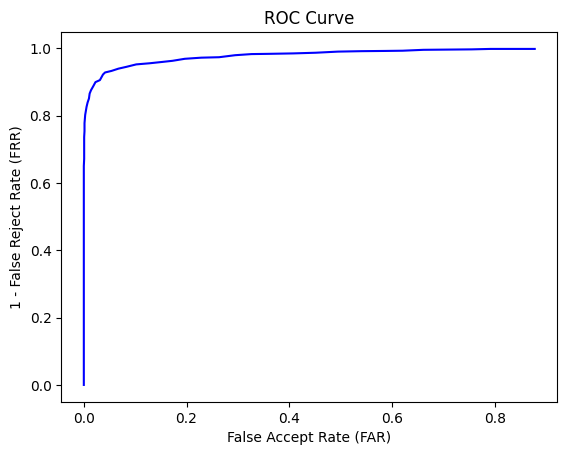

In [28]:
frr1 = [1-results[thresh]['FRR'] for thresh in thresholds]


plt.figure()
plt.plot(far, frr1, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

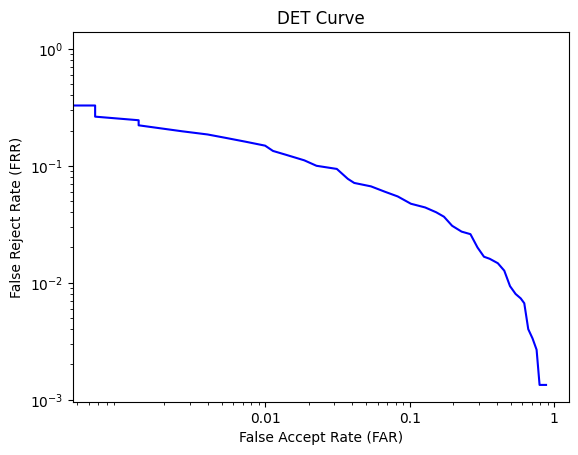

In [38]:
# Extract FAR and FRR values for plotting
fars = [results[thresh]['FAR'] for thresh in thresholds if thresh != 'inf']
frrs = [results[thresh]['FRR'] for thresh in thresholds if thresh != 'inf']

# Since 'inf' can't be plotted, we remove it from the list of thresholds
# Also, we ensure thresholds are sorted because the plotting assumes this order
sorted_indices = np.argsort(thresholds)
fars = np.array(fars)[sorted_indices]
frrs = np.array(frrs)[sorted_indices]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.xscale('log')
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.00f}'.format(x)))
plt.yscale('log')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')

plt.xticks([0.01, 0.1, 1], ['0.01', '0.1', '1'])


plt.show()